# Despligue de modelo para inferencias en Batch

En esta primera práctica vamos a aprender cómo desplegar un modelo para realizar inferencias en Batch. Para ello, utilizaremos Google Cloud Platform (GCP).

El objetivo de esta práctica es dados un conjunto de datos, primero generar un modelo que posteriormente pondremos a inferir de manera productiva sobre nuevos datos a gran escala.

Para almacenar los datos usaremos Google Cloud Storage y posteriormente generaremos un entrenamiento automatizado y predicciones usando Google Cloud Dataflow. Para todo el procesamiento relacionado con el modelo se programará en Python y usando Apache Beam.

Al acabar esta práctica seremos capaces de generar entrenamientos automáticos sobre un conjunto de datos y realizar predicciones en batch a gran escala.

# Introducción a Apache Beam


[Beam](https://beam.apache.org/) es un modelo unificado open-source de definición de Pipelines de procesamiento en batch y streaming. Beam es muy útil en tareas de procesamiento muy paralelas con alto volumen de datos.

La utilidad de Beam reside en la capacidad de difinir un único Pipeline tanto para realizar procesamientos en Batch y Streaming además de su capacidad de ejecutar en cualquier runtime actual como Spark, Flink o Dataflow.

## Conceptos clave de Apache Beam

*   Pipeline: entidad que encapsula la tarea de procesamiento, esto incluye leer datos de entrada, transformaciones y escribir datos de salida
*   PCollection: representa un set de datos distribuido con el que la Pipeline trabaja.
* PTransform: representa una operación de procesamiento dentro de un Pipeline.

Un flujo de ejecución de Beam sería de la siguiente forma.

1. Creamos un objeto Pipeline con su configuración (incluyendo el Runner donde va a ejecutar).
2. Leemos un PCollection de una fuente de datos o creamos una propia.
3. Aplicamos un PTransform definido en la Pipeline a cada PCollection que tengamos.
4. Ejecutamos el Pipeline en el Runner especificado.




## Entendiendo un Pipeline

In [ ]:
! pip install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp39-cp39-linux_x86_64.whl size=36912 sha256=8b6ff53c04599b22fdbb1aee5352690731e43f1fa97f24311e05daf25eef8f42
  Stored in directory: /root/.cache/pip/wheels/4a/6c/a6/f

Importamos Beam y empezamos a crear un pipeline utilizando un contexto. El contexto nos permite crear variables dentro de un entorno controlado.

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

with beam.Pipeline(options=PipelineOptions()) as pipeline:
  pass  # build your pipeline here

Vamos a crear nuestra primera colección. Para ello empleamos create. Llamaremos a nuestra pipeline: primera_pipeline.

Para añadir transformaciones usamos el operador pipe (|).

Para crear nuestra primera colección uasmos una lista de palabras:

In [ ]:
# Create a PCollection
with beam.Pipeline(options=PipelineOptions()) as primera_pipeline:
  words = (
      primera_pipeline | beam.Create([
            'hola',
            'hello',
            'saluts',
            'ciao',
        ]))


Hemos creado nuestra primera transformación. El input es la lista y la transformación es la creación de una colección.

Dentro de la claúsula `with` de Python definiremos las transformaciones a aplicar. Para encadenar transformaciones a la pipeline se usará el operador `|` como vemos a continuación: 

`[Output PCollection] = [Input PCollection] | [Transform]`

```
[Final Output PCollection] = ([Initial Input PCollection] | [First Transform]
                              | [Second Transform]
                              | [Third Transform])
```



El Final Output sería nuestra base de datos de la derecha en el diagrama que se construye a partir de las colecciones y transformaciones a la derecha del igual.

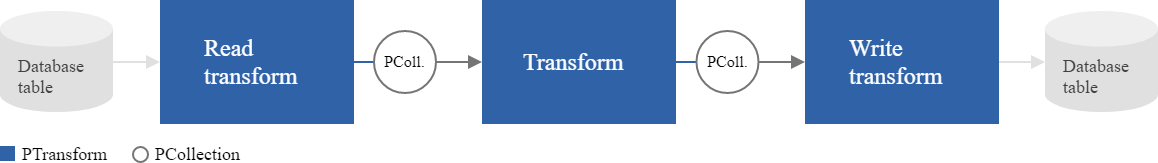

Los pipes nos permiten generar grafos de ejecución para diseñar los flujos a nuestro gusto. En el ejemplo siguiente vemos como primero leemos los datos y a continuación aplicamos dos transformaciones distintas que se pueden realizar en paralelo:

```
[PCollection of database table rows] = [Database Table Reader] | [Read Transform]
[PCollection of 'A' names] = [PCollection of database table rows] | [Transform A]
[PCollection of 'B' names] = [PCollection of database table rows] | [Transform B]
```

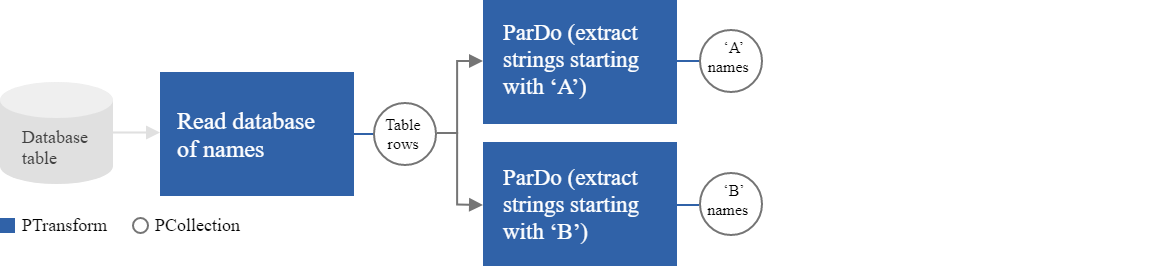

Apache Beam tiene una serie de Transformaciones básicas que podemos aplicar en nuestra Pipeline. Las fundamentales son las siguientes:

* ParDo
* GroupByKey
* CoGroupByKey
* Combine
* Flatten
* Partition

Nosotros nos vamos a centrar en la transformación ParDo. Esta transformación nos permite aplicar nuestro código Python sobre colecciones de datos. Esta ejecución se realiza en paralelo lo cual resulta muy eficiente a nivel computacional.

Para definir esta transformación tenemos que definir una clase de Python que herede de `beam.DoFn` y codificar nuestras operaciones en el método `process`. El método `process` es obligatorio y se tiene que llamar así.

En `element` irá la información que queremos procesar, por ejemplo, una fila de un dataframe.

In [ ]:
class ComputeWordLengthFn(beam.DoFn):
  def process(self, element):
    return [len(element)]

La gran ventaja es que dentro de nuestro process podemos usar todo tipo de librerías lo cual otorga una gran versatilidad a nuestro código.

In [ ]:
# Create a PCollection
with beam.Pipeline(options=PipelineOptions()) as pipeline_longitud:
  palabras = (
        pipeline_longitud | beam.Create([
            'hola',
            'hello',
            'saluts',
            'ciao',
        ]))
  palabras_lengths = palabras | beam.ParDo(ComputeWordLengthFn())

No se muestra nada porque está ejecutando por debajo. Para que nos muestre explícitamente los resultados debemos indicárselo.

En el caso de que nuestro código sea muy sencillo y podamos meterlo en una función lambda podemos usar la transformacion `FlatMap` para aplicarla sobre cada elemento de nuestra PCollection sin necesidad de crear una clase como en el ejemplo anterior. Esto será solo útil para procesos muy muy simples:

In [ ]:
# Create a PCollection
with beam.Pipeline(options=PipelineOptions()) as pipeline_longitud:
  palabras = (
        pipeline_longitud | beam.Create([
            'hola',
            'hello',
            'saluts',
            'ciao',
        ]))
  palabras_lengths = palabras | beam.FlatMap(lambda palabra: [len(palabra)])

Y si es aún más sencillo como en este caso que sólo aplicar la función `len` sobre cada elemento podemos usar la transformación `Map` que aplica la función indicada a cada elemento como puede ser un `len` o un `print`. Esto solo será posible cuando utilicemos métodos nativos de Python. En este caso, sacrificamos versatilidad (uso de módulos) a cambio de sencillez:

In [ ]:
# Create a PCollection
with beam.Pipeline(options=PipelineOptions()) as pipeline_longitud:
  palabras = (
        pipeline_longitud | beam.Create([
            'hola',
            'hello',
            'saluts',
            'ciao',
        ]))
  palabras_lengths = palabras | beam.Map(len)

Por último podemos ver cómo es cierto qué las pipelines calculan el resultado deseado:

In [ ]:
# Create a PCollection
with beam.Pipeline(options=PipelineOptions()) as pipeline_longitud:
  palabras = (
        pipeline_longitud | beam.Create([
            'hola',
            'hello',
            'saluts',
            'ciao',
        ]))
  palabras_lengths = palabras | beam.Map(len)
  palabras_print = palabras_lengths | beam.Map(print)

4
5
6
4


# ¡Manos a la obra!

Ahora vamos a comenzar con el desarrollo para el despliegue en batch. Va a constar de tres pipelines diferentes:

1.   **Pipeline de preprocesamiento**: en esta pipeline leeremos los datos de entrada de un fichero Google Cloud Storage y limpiaremos los datos
2.   **Pipeline de entrenamiento**: en esta pipeline usaremos los datos preprocesados para entrenar un modelo que prediga el sentimiento de un string de texto.
3. **Pipeline de inferencia**: esta pipeline cargará el modelo entrenado y realizará predicciones en batch en paralelo a gran escala.

**INTRODUCIR DIAGRAMA DE LA PRÁCTICA**

## Configuración de nuestro proyecto en GCP

**Los siguientes pasos es obligatorio realizarlos para seguir con la práctica.**

1.   Selecciona o crea un proyecto en GCP
2.   Asegurate de que la facturación está activada para tu proyecto.
3.   [Habilita la API de Google Cloud Storage](https://console.cloud.google.com/apis/library/storage-component.googleapis.com?q=storage).
4. [Habilita la API de Google Cloud Dataflow](https://console.cloud.google.com/apis/library/dataflow.googleapis.com?q=dataflow).
5. [Habilita la API de Google AI Platform](https://console.cloud.google.com/apis/library/ml.googleapis.com?q=ai%20platform).
6. Introduce tu ID de proyecto de GCP en la celda de abajo. Ejecuta la celda para asegurarnos de que el Cloud SDK usa el proyecto adecuado para todos los comandos en este notebook.

**Nota1**: No cierres las ventanas en las que habilitas la API hasta que el proceso de habilitación haya terminado.

**Nota2**: Jupyter ejecuta las lineas con el prefijo `!` como comandos shell de consola, y puede usar variables de Python en los comandos añadiendoles el prefijo `$`.

In [ ]:
PROJECT_ID = "puestaproduccionkcmarzo23" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


Importante. La cuenta con la que tengáis abierto el Google Colab debe ser la misma a la que tenemos asociada nuestra cuenta de la nube:

In [ ]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


## Creación bucket en Cloud Storage

**Los siguientes pasos son obligatorios.**

Cuando ejecutemos un job de entrenamiento usando el Cloud SDK, lo que hacemos es subir un paquete Python que contiene el código de entrenamiento a Google Cloud Storage. AI Platform ejecuta este paquete en el job.

Establece el nombre del bucket a continuación. El nombre tiene que ser **único** para todos los bucket de GCP, por lo que se recomienda nombres muy personales o que incluyan el timestamp. También tenemos que establecer la variable `REGION`, la cual usaremos para todas las operaciones a lo largo del notebook. Asegurate de [elegir una región en la que Cloud AI Platform esté disponible](https://cloud.google.com/ml-engine/docs/tensorflow/regions).

In [ ]:
BUCKET_NAME = "puestaproduccionkcmarzo23-art" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

**Sólo si tu bucket aún no existe**: Ejecuta la siguiente celda para crear tu bucket en Cloud Storage.

In [ ]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://puestaproduccionkcmarzo23-art/...


Finalmente, validamos que tenemos acceso al bucket de Cloud Storage mirando sus contenidos:

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

                                 gs://puestaproduccionkcmarzo23-art/data/
                                 gs://puestaproduccionkcmarzo23-art/twitter-sentiment-batch/


Podemos comprobar esto de una manera más visual yéndonos a la interfaz de Google Cloud, buscando el apartado Cloud Storage y comprobando que el bucket se ha creado.

## Descarga del Dataset y plantilla de código

Ahora, nos descargaremos el Dataset de Twitter llamado Sentiment140, que contiene más de 1M de tweets clasificados por sentimiento entre otros datos para su clasificación, podéis consultar más información [aquí](http://help.sentiment140.com/for-students).

Para la práctica sólo usaremos el campo `text` como feature de entrenamiento y `polarity` como label a predecir.

In [ ]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -P .

--2023-03-13 19:49:15--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-03-13 19:49:20--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘./trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  94.6MB/s    in 0.8s    

2023-03-13 19:49:21 (94.6 MB/s) - ‘./trainingandtestdata.zip’ saved [81363704/81363704]



Por otro lado, nos descargaremos la plantilla de código que vamos a ir rellenando para el desarrollo de la práctica y establecemos el directorio como directorio de trabajo:

In [ ]:
! git clone https://github.com/ArturoSanchezPalacio/TwitterBatch.git

Cloning into 'TwitterBatch'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 2.18 KiB | 1.09 MiB/s, done.


In [ ]:
# Set the working directory to the sample code directory
%cd TwitterBatch/twitter-sentiment-batch

/content/TwitterBatch/twitter-sentiment-batch


In [ ]:
!ls

predict-inicial.py  preprocess_inicial.py  requirements.txt  setup.py  trainer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora, procedemos a descomprimir el dataset:

In [ ]:
! mkdir ./data && unzip /content/trainingandtestdata.zip -d ./data && rm /content/trainingandtestdata.zip

Archive:  /content/trainingandtestdata.zip
  inflating: ./data/testdata.manual.2009.06.14.csv  
  inflating: ./data/training.1600000.processed.noemoticon.csv  


## Instalación de dependencias

Ejecutamos la siguiente celda para instalar las dependencias de Python necesarias para entrenar el modelo localmente y preprocesar datos. 

Cuando ejecutemos el job de entrenamiento en AI Platform, las dependencias estarán instaladas en base a la [versión del runtime](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list) elegido.

In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
# Nos aseguramos que nuestras variables de entorno no hayan desaparecido al reiniciar el kernel

print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Bucket: {BUCKET_NAME}")

Project: puestaproduccionkcmarzo23
Region: europe-west1
Bucket: puestaproduccionkcmarzo23-art


# End-2-End en local

Una vez tenemos todo configurado y entendemos los principios de Apache Beam vamos a comenzar con la productivización. Uno de los pilares principales es la automatización, por ello, vamos a automatizar a parametrizar las tres fases que vamos a tener, el preprocesamiento, el entrenamiento y la inferencia.

## Preprocesamiento

Para el preprocesado vamos a utilizar Apache beam sobre el dataset en bruto para paralelizar el procesamiento y que sea lo más eficiente posible.

Comenzamos estableciendo el directorio de trabajo:

In [ ]:
!ls

data		    preprocess_inicial.py  setup.py
predict-inicial.py  requirements.txt	   trainer


In [ ]:
import os

# Set the working directory to the sample code directory
#%cd ./twitter-sentiment-analysis-batch/

WORK_DIR = os.getcwd()

In [ ]:
WORK_DIR

'/content/TwitterBatch/twitter-sentiment-batch'

Las dos próximas celdas representan los comandos que vamos a utilizar para lanzar respectivamente el preprocesamiento de los datos de entrenamiento y de los datos de test. Pero antes de hacerlo, necestiamos construir nuestro script preprocess.py.

In [ ]:
! python3 preprocess_inicial.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data/training*.csv \
  --output $WORK_DIR/data/transformed_data \
  --mode train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
INFO:root:Default Python SDK image for environment is apache/beam_python3.9_sdk:2.46.0
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7f9e9532f040> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7f9e9532f160> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7f9e9532f670> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7f9e9532f700> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7f9e9532f8b0> ====================
INFO:apache_beam.runners.p

In [ ]:
! python3 preprocess_inicial.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data/test*.csv \
  --output $WORK_DIR/data/transformed_data \
  --mode test

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:root:Default Python SDK image for environment is apache/beam_python3.9_sdk:2.46.0
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7fbcf7c65040> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7fbcf7c65160> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7fbcf7c65670> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7fbcf7c65700> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7fbcf7c658b0> ====================
INFO:apache_beam.r

## Entrenamiento del modelo

Antes de entrenar el modelo en GCP a través de AI Platform, vamos a ejecutar en local para asegurarnos que el script funciona y el empaquetado es correcto.

Para una ejecución que sea muy pesada, primero queremos probar sobre una pequeña porción del dataset para verificar la correcta ejecución antes de ejecutar en GCP con el dataset completo.

Ejecuta la siguiente celda para entrenar el modelo localmente:

In [ ]:
! pip install --upgrade numpy scipy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


**Importante asegurarse de que nuestro entorno posee GPU o el proceso de entrenamiento tardará horas**

In [ ]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  -- \
  --work-dir $WORK_DIR \
  --epochs 1

Updated property [ml_engine/local_python].
2023-03-13 20:48:22.368396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 20:48:23.684317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-13 20:48:23.684478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-13 20:48:23.684524: W tensorflow/compiler/t

**Nota.** Esta celda tarda unos 25 minutos en ejecutar.

Entrenar en local nos permite debuggear y no gastar dinero de manera innecesaria. Como se suele utilizar es entrenando pequeños procesos en local y una vez que estamos seguros lanzando el entrenamiento grande en la Google Cloud.

## Predicciones en batch sobre texto

Después de entrenar nuestros modelos, podemos hacer predicciones en batch en nuestros ejemplos de test en local ejecutando la siguiente celda:

In [ ]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [ ]:
TIMESTAMP

'2023-03-13_21-17-37'

Usamos el timestamp para crear el nombre de nuestra carpeta de predicción y así tener trazabilidad de cuando se lanzaron las predicciones.

In [ ]:
! python3 predict-inicial.py \
  --work-dir $WORK_DIR \
  --model-dir $WORK_DIR/data/model \
  batch \
  --inputs-dir $WORK_DIR/data/transformed_data/test/part* \
  --outputs-dir $WORK_DIR/predictions/$TIMESTAMP

2023-03-13 21:29:15.090345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 21:29:16.091820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-13 21:29:16.091941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-13 21:29:16.091963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

Si exploramos el output de las predicciones podemos ver como en la primera ejecución ha tardado un poquito más debido a la función `setup` de la que hablamos antes en la que se cargan el tokenizador y el modelo.

# End-2-End en GCP

## Disponibilizar el dataset en Google Storage

Para lanzar nuestras primeras ejecuciones en GCP con Dataflow y AI Platform lo primero que haremos será subir el dataset a un bucket de Google Storage. Para subirlo ejecutaremos las siguientes celdas:

In [ ]:
! rm -rf ./data/transformed_data ./predictions #./data/model

In [ ]:
# %cd ../
! ls

data		    preprocess_inicial.py  setup.py
predict-inicial.py  requirements.txt	   trainer


Vamos a subir a nuestro bucket nuestros datos de entrenamiento y test así como nuestro modelo.

In [ ]:
! gsutil -m cp -r ./data gs://$BUCKET_NAME/twitter-sentiment-batch/data

Copying file://./data/testdata.manual.2009.06.14.csv [Content-Type=text/csv]...
Copying file://./data/training.1600000.processed.noemoticon.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://./data/model/tokenizer.pkl [Content-Type=application/octet-stream]...
Copying file://./data/model/model.h5 [Content-Type=application/x-hdf

Si vamos ahora a nuestro bucket podemos observar que todo se haya subido correctamente.

## Running our Workflow using DataFlow and AI Platform

Hasta ahora estábamos trabajando en colab usando como almacenamiento el Drive. Ahora lo que vamos a hacer es trabajar en la nube por lo que lo primero que debemos hacer es modificar nuestro directorio de trabajo:

In [ ]:
WORK_DIR = 'gs://' + BUCKET_NAME + '/twitter-sentiment-batch'

Comprobamos que se haya cambiado correctamente.

In [ ]:
! ls

data		    preprocess_inicial.py  setup.py
predict-inicial.py  requirements.txt	   trainer


Ahora nos aseguramos de haber ejecutado la celda de credenciales del notebook y procedemos.

Sin cambiar el código, y una vez que lo hemos depurado en loca, podemos pasar a entrenar nuestro modelo empleando recursos de Google Cloud.

Para ello debemos añadir unos pocos argumentos a la orden

In [ ]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $REGION \
  --runner DataflowRunner \
  --temp_location $WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $WORK_DIR \
  --input $WORK_DIR/data/training*.csv \
  --output $WORK_DIR/data/transformed_data \
  --mode train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:apache_beam.io.gcp.gcsio:Starting the size estimation of the input
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:apache_beam.io.gcp.gcsio:Finished listing 1 files in 2.368227958679199 seconds.
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmpytg2ov_i']


INFO:apache_beam.runners.portability.stager:Downloading source distribution of the SDK from PyPi
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', '-m', 'pip', 'download', '--dest', '/tmp/tmpytg2ov_i', 'apache-beam==2.24.0', '--no-deps', '--no-binary', ':all:']
INFO:apache_beam.runners.portability.stager:Staging S

Si esperamos unos segundos y accedemos a DataFlow a través de la consola podremos ver nuestro job ejecutando. 

En él podemos observar el grafo de ejecución y entender cómo funcionan las ejecuciones.

Una vez se haya lanzado el job podemos parar la celda y ejecutar la siguiente pues todo se está ya ejecutando en paralelo por detrás en la nube:

In [ ]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $REGION \
  --runner DataflowRunner \
  --temp_location $WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $WORK_DIR \
  --input $WORK_DIR/data/test*.csv \
  --output $WORK_DIR/data/transformed_data \
  --mode test

### A partir de aquí no vamos a ejecutar

A continuación vamos a lanzar el job de entrenamiento en la nube. Para ello modificamos de nuevo el directorio del job y añadimos de nuevo un nombre con fecha para el mismo

In [ ]:
JOB = "twitter_sentiment_analysis_batch_$(date +%Y%m%d_%H%M%S)"
JOB_DIR = WORK_DIR + "/trainer"

Enviamos un trabajo de training, le indicamos que módulo tiene que utilizar, qué recursos, qué versión de python y runtime (librería predefinidas de Google)...

Necesitamos que acaben de ejecutar los datos para lanzarlo y **tiene un coste**.

Recomiendo no ejecutarlo.

In [ ]:
! gcloud ai-platform jobs submit training $JOB \
  --module-name trainer.task \
  --package-path trainer \
  --scale-tier basic_gpu \
  --python-version 3.7 \
  --runtime-version 2.1 \
  --region $REGION \
  --job-dir $JOB_DIR \
  --stream-logs \
  -- \
  --work-dir $WORK_DIR \
  --epochs 3

In [ ]:
# Sample tokenizer.pkl...
! wget https://transfer.sh/LMlBX/tokenizer.pkl -O - | gsutil cp - gs://$BUCKET_NAME/models/tokenizer.pkl

In [ ]:
# Sample model.h5...
! wget https://transfer.sh/vqvNx/model.h5 -O - | gsutil cp - gs://$BUCKET_NAME/models/model.h5

In [ ]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

En la parte de inferencia podemos realizar inferencia en la nube a partir del modelo que hemos entrenado en local. De nuevo debemos esperar a que ejecute la parte de preprocesamiento para que esto funcione.

**Esta ejecucición cuesta dinero.**

Recomiendo no ejecutar.

In [ ]:
# For using sample models: --model-dir gs://$BUCKET_NAME/models/
! python3 predict.py \
  --work-dir $WORK_DIR \
  --model-dir gs://$BUCKET_NAME/models/ \
  batch \
  --project $PROJECT_ID \
  --region $REGION \
  --runner DataflowRunner \
  --temp_location $WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --inputs-dir $WORK_DIR/data/transformed_data/test/part* \
  --outputs-dir $WORK_DIR/predictions/$TIMESTAMP

Podemos explorar en la consola cómo avanza el job.